In [128]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os
import urllib.request as urlreq
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.color import label2rgb
import json
import sklearn.mixture
import pickle as pkl

/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_67279/2765325046.py:184: RuntimeWarning: divide by zero encountered in divide
  adjustment_factor = target_means / source_means
/var/folders/zc/s2x1jcqx7gd7y6myf0gmt49c0000gn/T/ipykernel_67279/2765325046.py:185: RuntimeWarning: invalid value encountered in multiply
  adjustment_factor = np.dstack([shadow_mask]*3) * (adjustment_factor - 1)


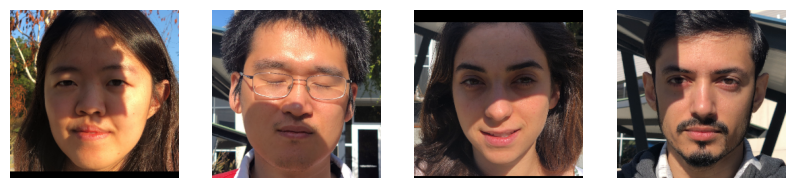

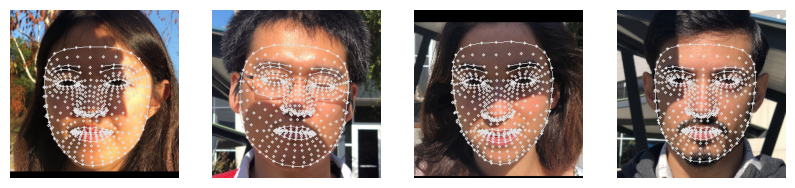

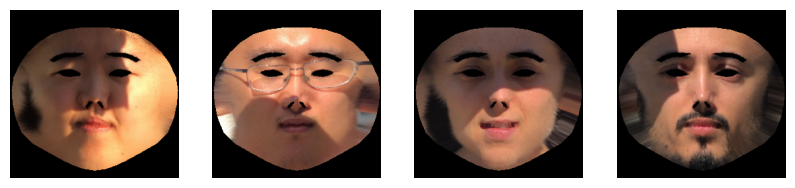

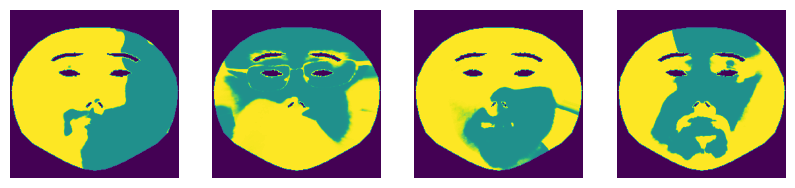

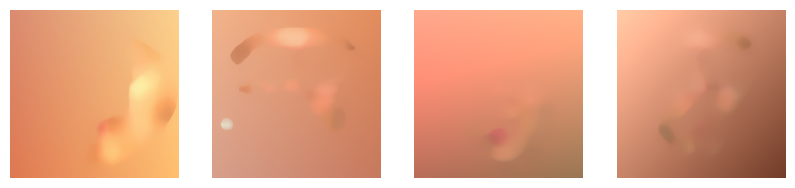

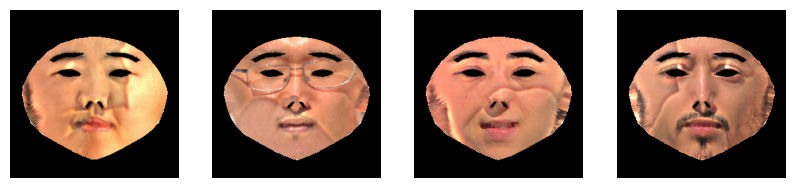

In [487]:
validation_paths = [
    "images/9156-004.png",
    "images/9162-031.png",
    "images/9165-009.png",
    "images/9169-020.png"
]
images = [(plt.imread(path) * 255).astype(np.uint8) for path in validation_paths]

uv_path = "uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

def display_images(images):
    # display images as a row of subfigures
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i])
        plt.axis('off')

def detect_face(image):
    # save face detection algorithm's url in haarcascade_url variable
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
    # save face detection algorithm's name as haarcascade
    haarcascade = "haarcascade_frontalface_alt2.xml"
    # chech if file is in working directory
    if not (haarcascade in os.listdir(os.curdir)):
        urlreq.urlretrieve(haarcascade_url, haarcascade)
    # create an instance of the Face Detection Cascade Classifier
    detector = cv2.CascadeClassifier(haarcascade)

    # Detect faces using the haarcascade classifier on the "grayscale image"
    faces = detector.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    if len(faces) > 0:
        return faces[0]
    else:
        return np.array([0, image.shape[1], 0, image.shape[0]])

def display_bounding_boxes(images, bounding_boxes):
    image_templates = [image.copy() for image in images]
    for i, bounding_box in enumerate(bounding_boxes):
        (x,y,w,d) = bounding_box
        cv2.rectangle(image_templates[i],(x,y),(x+w, y+d),(255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks(image, bounding_box):
    # save facial landmark detection model's url in LBFmodel_url variable
    LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
    # save facial landmark detection model's name as LBFmodel
    LBFmodel = "LFBmodel.yaml"
    # check if file is in working directory
    if not (LBFmodel in os.listdir(os.curdir)):
        urlreq.urlretrieve(LBFmodel_url, LBFmodel)
    # create an instance of the Facial landmark Detector with the model
    landmark_detector  = cv2.face.createFacemarkLBF()
    landmark_detector.loadModel(LBFmodel)
    # Detect landmarks on "image_gray"
    _, landmarks = landmark_detector.fit(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), np.array([bounding_box]))
    if len(landmarks) > 0:
        return landmarks[0]
    else:
        return np.zeros((68, 2))

def display_landmarks(images, landmarks):
    image_templates = [image.copy() for image in images]
    for i, landmark_set in enumerate(landmarks):
        for landmark in landmark_set[0]:
            x, y = landmark
            cv2.circle(image_templates[i], (int(x), int(y)), 1, (255, 255, 255), 2)
    display_images(image_templates)

def detect_landmarks_3D(image):
    NUM_FACE = 1
    mpFaceMesh = mp.solutions.face_mesh
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=NUM_FACE)
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(imgRGB)
    if results.multi_face_landmarks:
        return results.multi_face_landmarks[0]
    else:
        return None
    
def convert_landmarks_to_2D(landmarks_3D):
    return np.array([(point.x, point.y) for point in landmarks_3D.landmark[0:468]])
    
def display_landmarks_3D(images, landmarkss):
    img_templates = [image.copy() for image in images]
    for i, landmarks in enumerate(landmarkss):
        mpDraw = mp.solutions.drawing_utils
        drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1)
        img = img_templates[i]
        mpFaceMesh = mp.solutions.face_mesh
        mpDraw.draw_landmarks(img, landmarks, mpFaceMesh.FACEMESH_CONTOURS, drawSpec, drawSpec)
        for id,lm in enumerate(landmarks.landmark):
            ih, iw, ic = img.shape
            x,y = int(lm.x*iw), int(lm.y*ih)
    display_images(img_templates)

def detect_edges(image):
    # blur the image
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    # apply canny edge detection algorithm on the image
    return cv2.Canny(blurred_image, 25, 100)

def unwrap_face(image, landmarks):
    H_new,W_new = image.shape[0],image.shape[1]
    keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
    keypoints = np.array([(W_new*point.x,H_new*point.y) for point in landmarks.landmark[0:468]])

    tform = PiecewiseAffineTransform()
    tform.estimate(keypoints_uv, keypoints)
    texture = warp(image, tform, output_shape=(H_new,W_new))
    texture = (255*texture).astype(np.uint8)

    return texture

def discard_eyes_eyebrows_and_nostrils(image, points):
    with open("triangulation.pkl", "rb") as f:
        triangles = pkl.load(f)
    triangles_to_discard = np.array([835, 760, 761, 757, 528, 527, 386, 387, 386, 387, 505, 506,
                            507, 535, 675, 771, 764, 763, 411, 412, 285, 286, 407, 406, 550, 551,
                            552, 684, 776, 777, 291, 294, 272, 547, 548, 543, 402, 253, 375, 376,
                            374, 249, 248, 373, 588, 589, 486, 342, 485, 587, 717, 716, 718,
                            720, 721, 613, 387, 386, 719])
    # find pixels within the triangles
    mask = np.ones(image.shape[:2], dtype=bool)
    for triangle_index in triangles_to_discard:
        triangle = points[triangles[triangle_index]][:, ::-1] * np.array([image.shape[1], image.shape[0]])
        if triangle[:, 0].max() > 125 and triangle[:, 0].max() < 150:
            print(triangle_index)
        mask = mask ^ skimage.draw.polygon2mask(image.shape[:2], triangle)
    return image * mask[:, :, np.newaxis]
        
def identify_shadow_distribution(unwrapped_face):
    # Get non-black pixels.
    face_pixels = unwrapped_face.reshape(-1, 3)
    face_pixels = face_pixels[np.sum(face_pixels, axis=1) > 0]
    lab_face_pixels = skimage.color.rgb2lab(face_pixels.reshape(1, -1, 3)).reshape(-1, 3)
    # Fit a Gaussian mixture model.
    gmm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type="diag")
    gmm.fit(lab_face_pixels)
    return gmm

def generate_shadow_probability(unwrapped_face, model):
    face_pixels = unwrapped_face.reshape(-1, 3)
    face_pixels = face_pixels[np.sum(face_pixels, axis=1) > 0]
    lab_face_pixels = skimage.color.rgb2lab(face_pixels.reshape(1, -1, 3)).reshape(-1, 3)
    gmm = model
    probabilities = gmm.predict_proba(lab_face_pixels)[:, 0]
    predictions = probabilities > 0.5
    if np.mean(face_pixels[predictions == 0], axis=0)[0] < np.mean(face_pixels[predictions == 1], axis=0)[0]:
        probabilities = 1 - probabilities
    mask = np.zeros(unwrapped_face.shape[:2])
    mask[np.sum(unwrapped_face, axis=2) > 0] = probabilities
    mask[np.sum(unwrapped_face, axis=2) <= 0] = -1
    return mask

def generate_imputed_mean_color(unwrapped_face, shadow_probability):
    shadow_mask = (shadow_probability < 0.5).astype(np.uint8)
    shadow_mask_dilated = cv2.erode(shadow_mask, np.ones((11, 11), np.uint8), iterations=1)
    data = unwrapped_face * shadow_mask_dilated[:,:,np.newaxis]
    # create 256x256x2 array of xy coordinates
    xy = np.dstack(np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0])))
    # add as channels of data
    data = np.dstack([xy, data])
    data = data.reshape(-1, 5).astype(np.float32)
    mask = data[:, -3:].sum(axis=1) == 0
    poly = sklearn.preprocessing.PolynomialFeatures(1)
    X_train = poly.fit_transform(data[~mask, :-3])
    X_test = poly.transform(data[mask, :-3])
    data[mask, -3:] = sklearn.linear_model.LinearRegression().fit(X_train, data[~mask, -3:]).predict(X_test)

    imputed = data.reshape(256, 256, 5)[:,:,-3:]
    existing_pixels = unwrapped_face * shadow_mask[:,:,np.newaxis]
    add_mask = np.dstack([imputed.sum(axis=2) > existing_pixels.sum(axis=2)]*3)
    color = (imputed * add_mask + existing_pixels * (1 - add_mask)).clip(0,255).astype(np.uint8)
    color = cv2.medianBlur(color, 29)
    return color

def remove_shadow_naive(unwrapped_face, mean_color_map, shadow_probability):
    target_means = mean_color_map
    source_means = cv2.medianBlur(unwrapped_face, 23)
    shadow_mask = shadow_probability > 0.5
    adjustment_factor = target_means / source_means
    adjustment_factor = np.dstack([shadow_mask]*3) * (adjustment_factor - 1)
    adjustment_factor = cv2.GaussianBlur(adjustment_factor, (29, 29), 0)
    unshadowed_face = (unwrapped_face * (1 + adjustment_factor)).clip(0, 255).astype(np.uint8)
    return unshadowed_face

display_images(images)
landmarks_3D = [detect_landmarks_3D(image) for image in images]
display_landmarks_3D(images, landmarks_3D)
without_eyes_eyebrows_and_nostrils = [discard_eyes_eyebrows_and_nostrils(image, convert_landmarks_to_2D(landmarks)) for image, landmarks in zip(images, landmarks_3D)]
unwrapped_faces = [unwrap_face(image, landmarks) for image, landmarks in zip(without_eyes_eyebrows_and_nostrils, landmarks_3D)]
display_images(unwrapped_faces)
shadow_distributions = [identify_shadow_distribution(unwrapped_face) for unwrapped_face in unwrapped_faces]
mean_color_displacements = [gmm.means_[np.argmax(gmm.means_.mean(axis=1))] - gmm.means_[np.argmin(gmm.means_.mean(axis=1))] for gmm in shadow_distributions]
shadow_probabilities = [generate_shadow_probability(unwrapped_face, shadow_distribution) for unwrapped_face, shadow_distribution in zip(unwrapped_faces, shadow_distributions)]
display_images(shadow_probabilities)
color_displacement_maps = [np.dstack([shadow_mask] * 3) * displacement for shadow_mask, displacement in zip(shadow_probabilities, mean_color_displacements)]

mean_color_maps = [generate_imputed_mean_color(unwrapped_face, shadow_probability) for unwrapped_face, shadow_probability in zip(unwrapped_faces, shadow_probabilities)]
display_images(mean_color_maps)
unshadowed_images = [remove_shadow_naive(unwrapped_face, mean_color_map, shadow_probability) for unwrapped_face, mean_color_map, shadow_probability in zip(unwrapped_faces, mean_color_maps, shadow_probabilities)]
display_images(unshadowed_images)